# 「プチ」勉強会 20230722
* 時系列データをやってみた。難しいと言われているが、それは予測モデルのAPIにデータの形式を合せるところが通常のテーブルデータの問題と異なるから。
* また、目的変数の時系列以外の特徴量の作り方にも工夫が要るが、そこさえわかればあとは特段難しい要素はない。（つまり、単に知識、テクニックの問題）
* 寧ろ、スコアを纏めるのは簡単。典型的な時系列特徴量からデータに合うものを選択するだけでよい。（いわゆる最適化）
* 但し、特定の月に最適化するのでなく、普遍的に予測するモデルとなると難易度はとんでもなく上がる。そして私はそれは不可能だと思っている。
* その他のテーブルデータの特徴量はアノマリー的な要素が見出せば効くが、そもそも時系列特徴量の最適化の影響が大きいので区別して考えた方が良いと思う。
* そういう意味ではいつもと少し勝手が異なるが、EDAはいつも通りいろいろ弄ってみた。めっちゃ遊べます。

## 今回取り組んでみたこと

1. まずは、時系列データを予測モデルのAPIに適合させるところを実際データ加工して覚えた。一度はやらないと分からないから。
```
   ・最終的にテーブルデータと同じ形式にしなければならない。つまり、「目的変数列と特徴量列があるテーブルデータ」にするということ。
   ・なにげに元のデータ量が200万以上あるので、迂闊に弄れない。オーバーフローしないよう慎重にすすめた。（実際、何度か止まった）
   ・時系列データなので、グラフによる視覚化がポイント。グラフが書けた時点で凡その結論は知れる。
```
2. 改めて、時系列予測、つまり、将来起こることを機械学習で予測することの意味を考えた。
```
   ・過去に起こったことが将来も繰り返す、あるいは趨勢を引き継ぐということは振り返れば実際よく見られること。
   ・だからといってそれを予測する精度が機械学習を用いると上がるというのは「誤解」ではないかと思う。
   ・「不確定」の本質は、それが「絶対に不確定」であるということ、および「その程度や頻度も不確定」ということ。
   ・特に経済活動に関することは常に大幅に変化し続けている。相互に影響を与える要素が多すぎてモデル化自体が難しい。
   ・さらにパターン的な要素も決して永続的ではなくさまざまに変化していくのでモデル化は常に後追いの理論となる。
   ・機械学習を魔法の杖と信じるひとは非線形な関係性を紡ぎだすモデルに期待するが、最適化＝過学習に過ぎないだろう。全ては所詮過去の話だ。
   ・そのことをこのデータとPythonを用いて少し見てみた。これが弄りだすとまたキリがないくらい楽しいのが難点。
```


## 音楽・ゲームソフト・玩具販売の業界の売上個数を予測しよう

In [1]:
# ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats
%matplotlib inline

from sklearn.linear_model import LinearRegression as LR         # 重回帰
from sklearn import tree                                        # 回帰木
from sklearn.ensemble import RandomForestRegressor as RFG       # ランダムフォレスト
import lightgbm as lgb                                          # Light GBM

from sklearn.model_selection import train_test_split            # データ分割
from sklearn.metrics import mean_squared_error, r2_score        # MSE, 決定係数r2
import lightgbm as lgb                                          # Light GBM

from collections import Counter, defaultdict                    # collectionsライブラリ
from pprint import pprint
import warnings
warnings.simplefilter('ignore')

# 表示の設定
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%precision 3
pd.options.display.precision = 3

sns.set(style='white')
import japanize_matplotlib

In [2]:
# 訓練用データ
df = pd.read_csv('C:\\Users\\yuich\\KC_data\\sales\\train.csv')
# 提出用データ
df_test = pd.read_csv('C:\\Users\\yuich\\KC_data\\sales\\test.csv')

# EDAのために一旦、全部読み込む

## データ概観

In [3]:
# 訓練データ

display(df.info())
display(df.head())
display(df.describe())
display(df.describe(include='object'))

# 提出用データ
display(df_test.info())
display(df_test.head())


# 欠損値 ： なし
# でも、データ数が2,882,335個もある！メモリに気を付けないと死にます。

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2882335 entries, 0 to 1793680
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                object 
 1   date_block_num      int64  
 2   shop_id             int64  
 3   item_id             int64  
 4   item_price          float64
 5   shop_name           object 
 6   item_name           object 
 7   item_category_id    int64  
 8   item_category_name  object 
 9   item_cnt_day        float64
dtypes: float64(2), int64(4), object(4)
memory usage: 241.9+ MB


None

,date,date_block_num,shop_id,item_id,item_price,shop_name,item_name,item_category_id,item_category_name,item_cnt_day
0,02.01.2013,0,59,22154,999.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,1.0
536424,22.01.2013,0,26,4907,1499.0,"Москва ТЦ ""Ареал"" (Беляево)","Mortal Kombat. Komplete Edition [Xbox 360, рус...",23,Игры - XBOX 360,1.0
536423,11.01.2013,0,26,4907,1799.0,"Москва ТЦ ""Ареал"" (Беляево)","Mortal Kombat. Komplete Edition [Xbox 360, рус...",23,Игры - XBOX 360,1.0
246988,08.01.2013,0,23,2258,299.0,"Москва ТК ""Буденовский"" (пав.А2)","Call Of Duty: Modern Warfare 3. DLC ""Коллекция...",28,Игры PC - Дополнительные издания,1.0
246989,23.01.2013,0,23,2258,299.0,"Москва ТК ""Буденовский"" (пав.А2)","Call Of Duty: Modern Warfare 3. DLC ""Коллекция...",28,Игры PC - Дополнительные издания,1.0


,date_block_num,shop_id,item_id,item_price,item_category_id,item_cnt_day
count,2.882e+06,2.882e+06,2.882e+06,2.882e+06,2.882e+06,2.882e+06
mean,1.423e+01,3.303e+01,1.019e+04,8.847e+02,3.996e+01,1.241e+00
std,9.166e+00,1.623e+01,6.327e+03,1.716e+03,1.708e+01,2.283e+00
min,0.000e+00,0.000e+00,0.000e+00,-1.000e+00,0.000e+00,-2.200e+01
25%,6.000e+00,2.200e+01,4.466e+03,2.490e+02,2.800e+01,1.000e+00
50%,1.300e+01,3.100e+01,9.250e+03,3.990e+02,4.000e+01,1.000e+00
75%,2.200e+01,4.700e+01,1.569e+04,9.990e+02,5.500e+01,1.000e+00
max,3.200e+01,5.900e+01,2.217e+04,3.080e+05,8.300e+01,1.000e+03


,date,shop_name,item_name,item_category_name
count,2882335,2882335,2882335,2882335
unique,1003,59,21332,84
top,28.12.2013,"Москва ТЦ ""Семеновский""",Фирменный пакет майка 1С Интерес белый (34*42)...,Кино - DVD
freq,9434,230779,30472,557379


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   item_id         22170 non-null  int64
 1   date_block_num  22170 non-null  int64
dtypes: int64(2)
memory usage: 346.5 KB


None

,item_id,date_block_num
0,0,33
1,1,33
2,2,33
3,3,33
4,4,33


## EDA（データ探索）

```Dataset.columns

item_cnt_day       : 各店舗における各商品の１日あたりの売上個数
shop_id            : 店ごとに振り分けられた番号
item_id            : 商品ごとに振り分けられた番号
item_category_id   : カテゴリーごとに振られた番号
item_price         : 商品の値段
date               : 年/月/日  ⇒　日/月/年が正しい
date_block_num     : 連続した月の番号 (2013/01を0として１ヶ月ごとに1加える)
item_name          : 商品名
shop_name          : 店名
item_category_name : カテゴリー名
```

In [4]:
# 欠損値の再確認

df.isnull().sum()

# df.describe()のcount数でも確認できるが、欠損値がないことを改めて確認
# データ数が多すぎてdf.info()では数が確認できない

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
shop_name             0
item_name             0
item_category_id      0
item_category_name    0
item_cnt_day          0
dtype: int64

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
item_cnt_day,1.0,2.0,3.0,4.0,5.0,-1.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,20.0
total_sales,2581638,190828,46440,19229,10254,7124,6184,3964,2835,2115,1777,1225,1053,893,695,611,525,424,385,354
pct,89.69%,6.63%,1.61%,0.67%,0.36%,0.25%,0.21%,0.14%,0.10%,0.07%,0.06%,0.04%,0.04%,0.03%,0.02%,0.02%,0.02%,0.01%,0.01%,0.01%


<Axes: xlabel='item_cnt_day'>

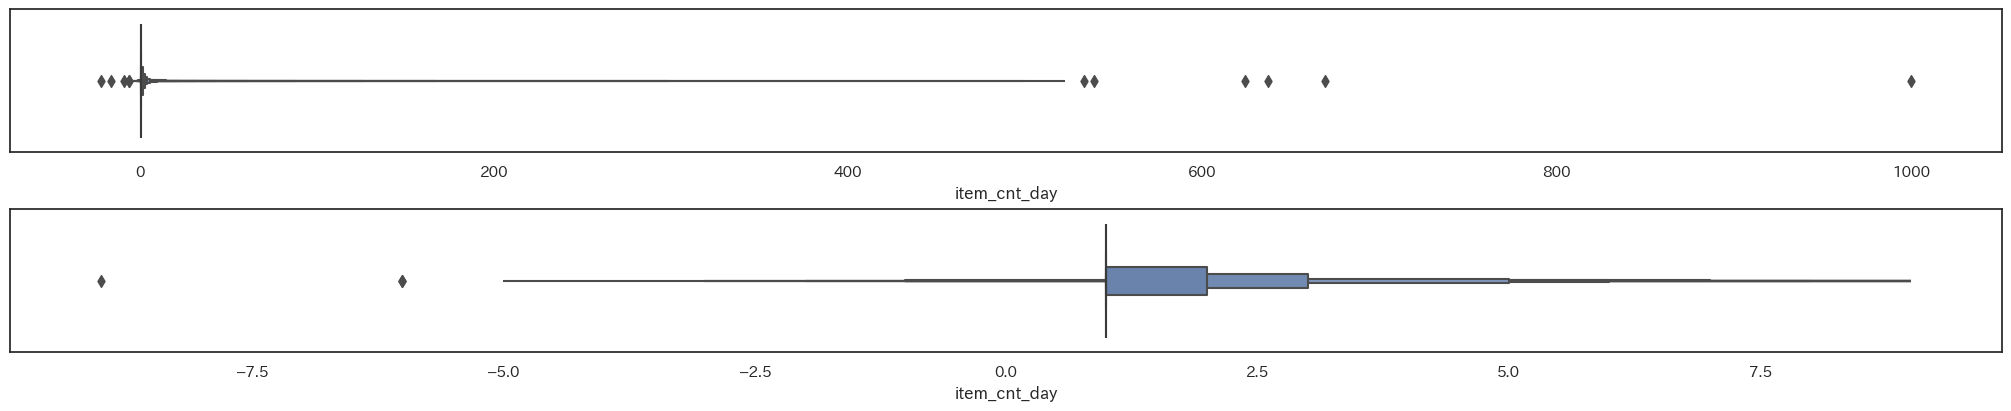

In [5]:
# item_cnt_day

df_top_20sales = pd.DataFrame().from_dict(Counter(df['item_cnt_day']).most_common()[:20])
df_top_20sales.columns=['item_cnt_day', 'total_sales']
df_top_20sales['pct'] = (df_top_20sales['total_sales'] 
                         / df_top_20sales['total_sales'].sum()).apply('{:.2%}'.format)
display(df_top_20sales.T)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,4), layout='constrained')
sns.boxenplot(data=df, x='item_cnt_day', ax=ax1)
sns.boxenplot(data=df[(df['item_cnt_day'] > -10) & (df['item_cnt_day'] < 10)], x='item_cnt_day', ax=ax2)

# 売上データの9割は売上1。つまり、ほとんどのケースでは何か売れる毎に1計上していると推定できる。
# また、たまにマイナスの売上が計上されていることもわかる。返品みたいなものか。数は僅少で影響なさそう。

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
date_block_num,0.0,1.0,2.000,3.0,4.0,5.000,6.0,7.0,8.000,9.000,10.0,11.000,12.000,13.000,14.0,15.000,16.000,17.000,18.000,19.000,20.000,21.000,22.000,23.000,24.000,25.000,26.000,27.000,28.000,29.000,30.000,31.000,32.000
item_cnt_day,131479.0,128090.0,147142.000,107190.0,106970.0,125381.000,116966.0,125291.0,133332.000,127541.000,130009.0,183342.000,116899.000,109687.000,115297.0,96556.000,97790.000,97429.000,91280.000,102721.000,99208.000,107422.000,117845.000,168755.000,110971.000,84198.000,82014.000,77827.000,72295.000,64114.000,63187.000,66079.000,72843.000
3m_ave,NaN,NaN,135570.333,127474.0,120434.0,113180.333,116439.0,122546.0,125196.333,128721.333,130294.0,146964.000,143416.667,136642.667,113961.0,107180.000,103214.333,97258.333,95499.667,97143.333,97736.333,103117.000,108158.333,131340.667,132523.667,121308.000,92394.333,81346.333,77378.667,71412.000,66532.000,64460.000,67369.667
6m_ave,NaN,NaN,NaN,NaN,NaN,124375.333,121956.5,121490.0,119188.333,122580.167,126420.0,136080.167,136069.000,133468.333,130462.5,125298.333,119928.500,105609.667,101339.833,100178.833,97497.333,99308.333,102650.833,114538.500,117820.333,114733.167,111867.500,106935.000,99343.333,81903.167,73939.167,70919.333,69390.833


(-0.500, 32.500)

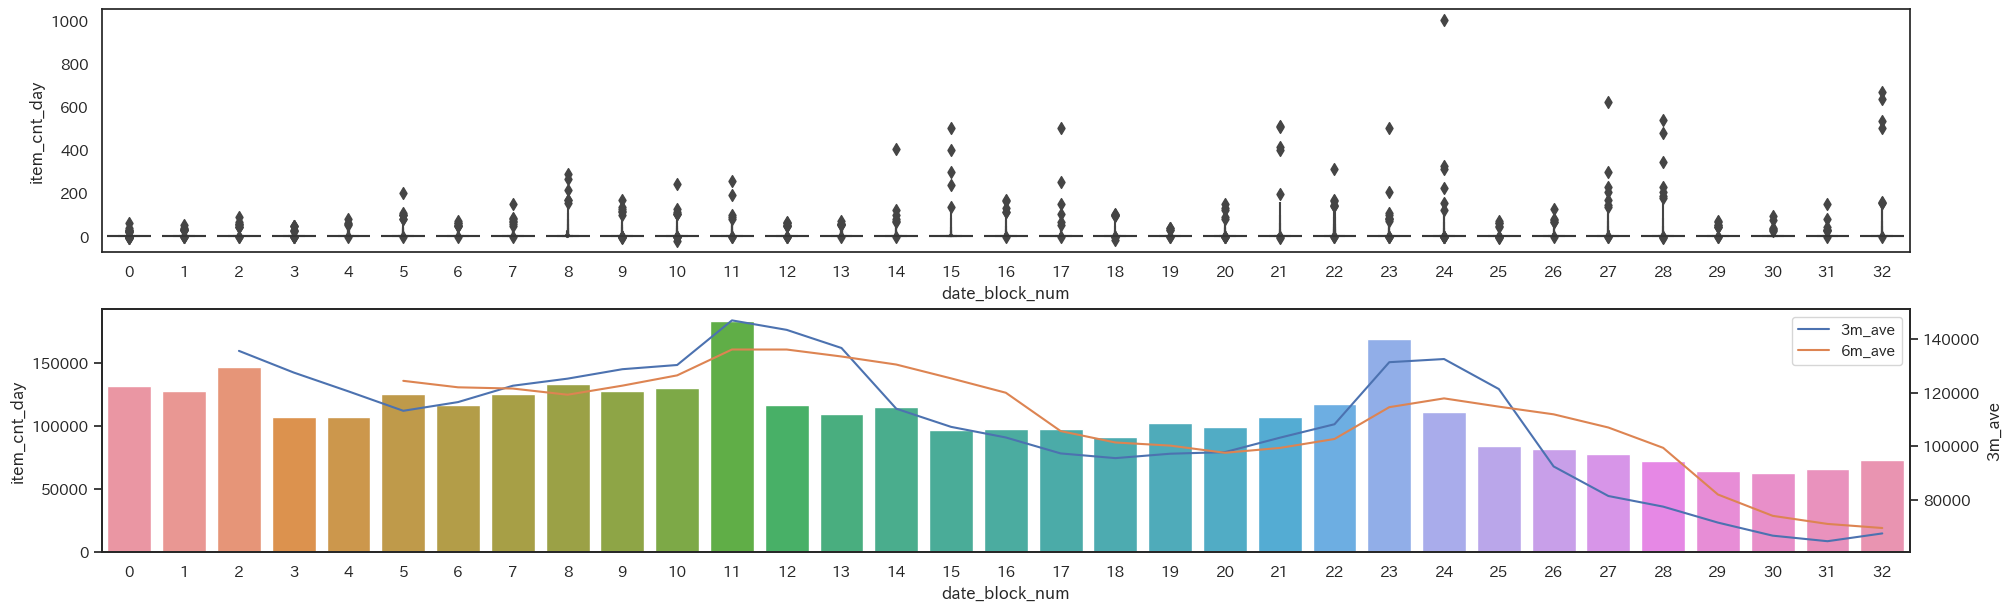

In [6]:
# date_block_num

df_sum = df.groupby('date_block_num')['item_cnt_day'].sum().reset_index()
df_sum['3m_ave'] = df_sum['item_cnt_day'].rolling(window=3).mean()
df_sum['6m_ave'] = df_sum['item_cnt_day'].rolling(window=6).mean()
display(df_sum.T)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,6), layout='constrained')
sns.boxenplot(data=df, x='date_block_num', y='item_cnt_day', ax=ax1)
sns.barplot(data=df_sum, x='date_block_num', y='item_cnt_day', ax=ax2)
axt = ax2.twinx()
sns.lineplot(data=df_sum, x='date_block_num', y='3m_ave', label='3m_ave', ax=axt)
sns.lineplot(data=df_sum, x='date_block_num', y='6m_ave', label='6m_ave', ax=axt)
axt.legend()
ax2.set_xlim(-0.5, 32.5)

# 最初の1年より売上のばらつきが拡大しているように見える
# 売上には季節性があり、また、全体的に減少傾向に見える
# 時系列予測としては、このグラフの延長戦上に答えが見える。その他のどのような特徴量もあまり意味はないだろう。

In [7]:
# date

display(df.groupby(['date_block_num', 'date'])[['item_cnt_day']].sum().head(50))

# 時系列データの問題なのでdateをdatetimeに変換して時系列として処理することもできる
# しかし、date_block_numで月単位に纏めることが出来、且つ、予想も月単位なのでこのデータは取り敢えず無視してOK
# でも、一応、全て特徴量をひとつ作る方針

item_cnt_day
date_block_num date                    
0              01.01.2013        1951.0
               02.01.2013        8198.0
               03.01.2013        7422.0
               04.01.2013        6617.0
               05.01.2013        6346.0
               06.01.2013        5858.0
               07.01.2013        4984.0
               08.01.2013        4772.0
               09.01.2013        3162.0
               10.01.2013        3142.0
               11.01.2013        3829.0
               12.01.2013        5443.0
               13.01.2013        4475.0
               14.01.2013        2595.0
               15.01.2013        3137.0
               16.01.2013        3033.0
               17.01.2013        3096.0
               18.01.2013        3682.0
               19.01.2013        6044.0
               20.01.2013        5111.0
               21.01.2013        2636.0
               22.01.2013        2775.0
               23.01.2013        2727.0
               24.01.2013        3016.0
               25.01.2013        4244.0
               26.01.2013        6267.0
               27.01.2013        5273.0
               28.01.2013        2852.0
               29.01.2013        2764.0
               30.01.2013        3042.0
               31.01.2013        2986.0
1              01.02.2013        3817.0
               02.02.2013        6145.0
               03.02.2013        5068.0
               04.02.2013        2330.0
               05.02.2013        3302.0
               06.02.2013        2974.0
               07.02.2013        3760.0
               08.02.2013        4430.0
               09.02.2013        6802.0
               10.02.2013        5511.0
               11.02.2013        3414.0
               12.02.2013        3622.0
               13.02.2013        3780.0
               14.02.2013        4024.0
               15.02.2013        4267.0
               16.02.2013        6643.0
               17.02.2013        5865.0
               18.02.2013        3203.0
               19.02.2013        4228.0

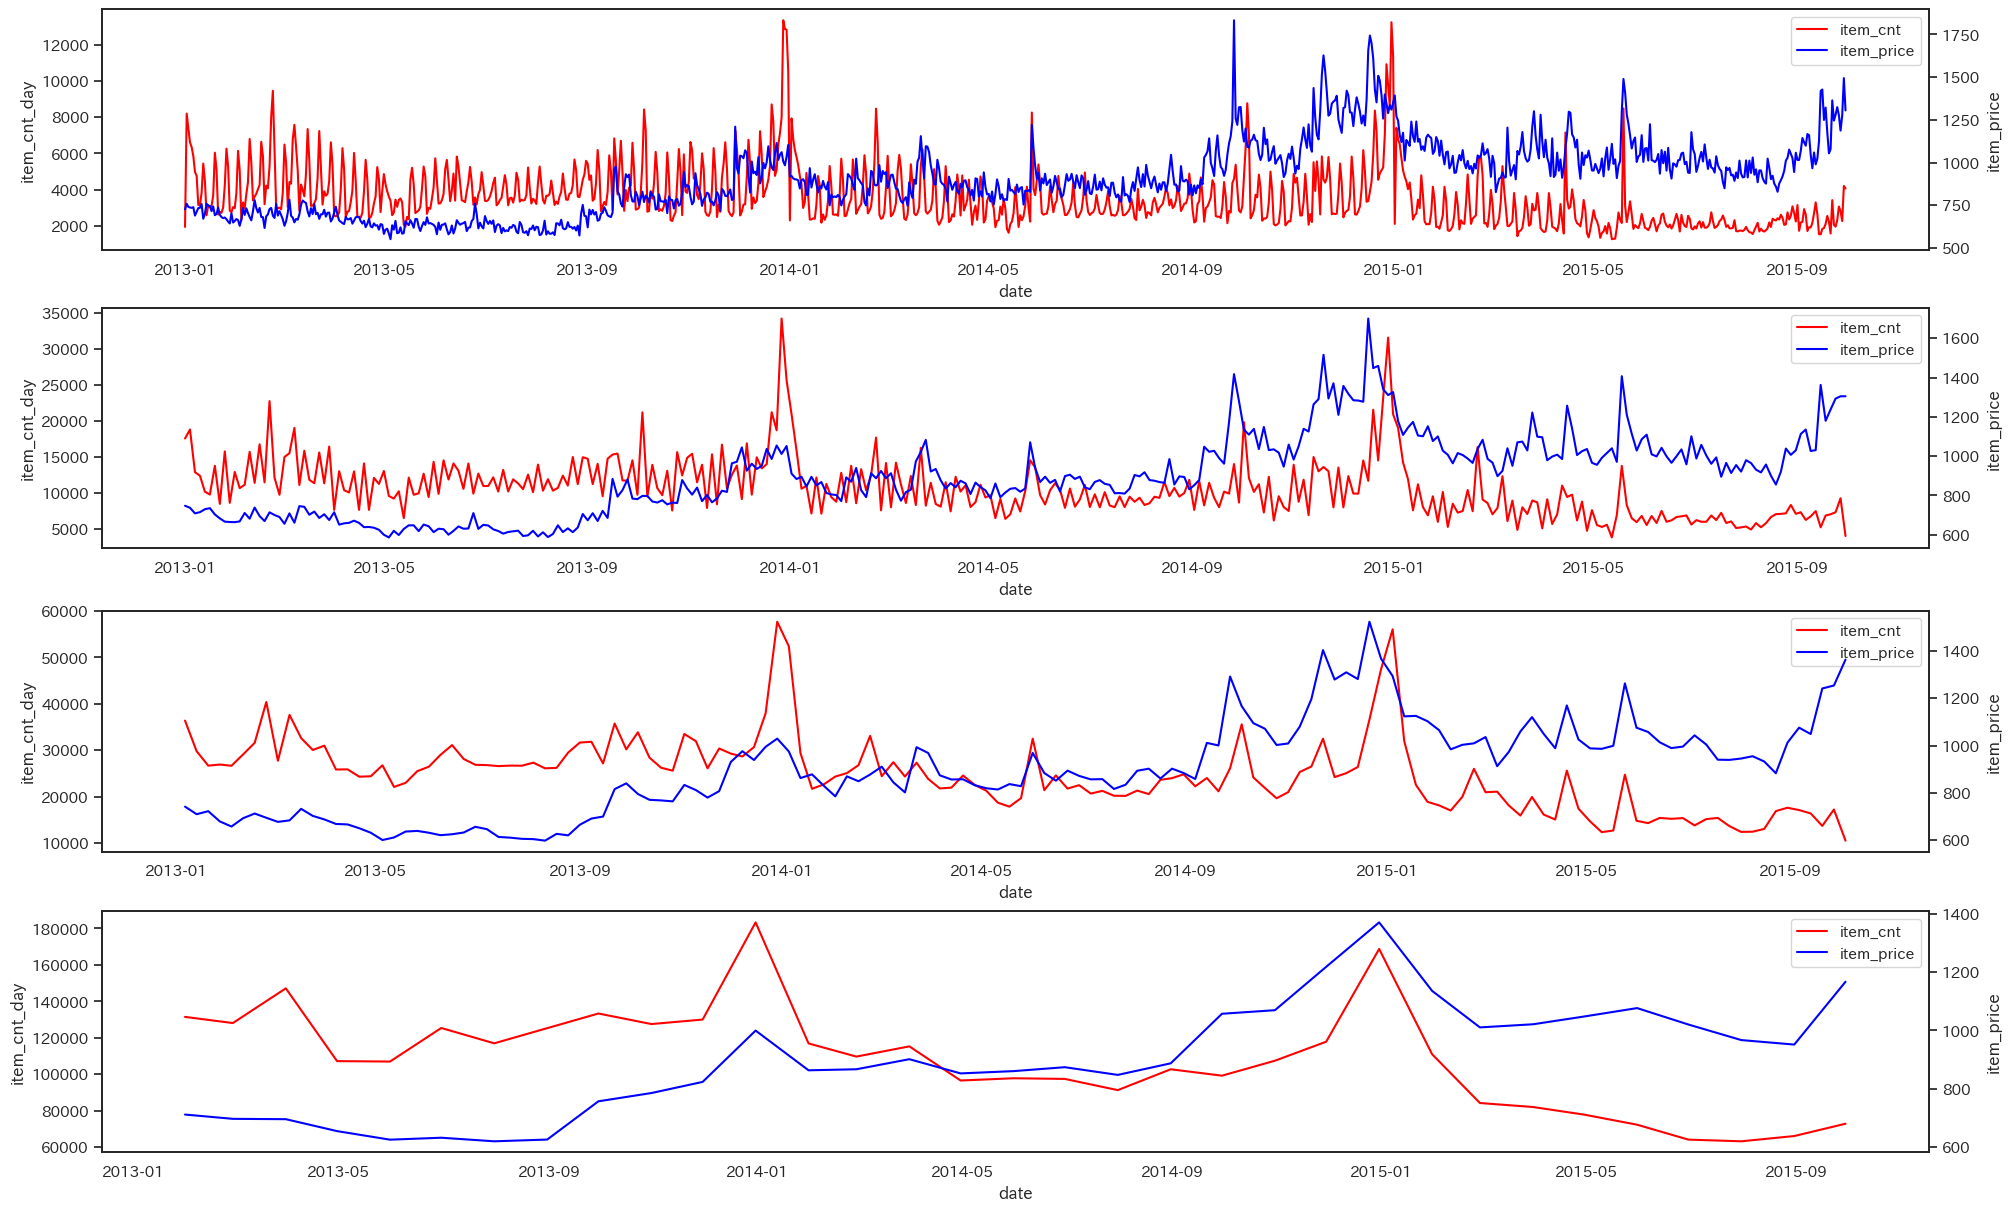

In [8]:
# date2 & price

df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
df.head()
df_10 = df.resample('D', on='date')['item_cnt_day'].sum()
df_11 = df.resample('D', on='date')['item_price'].mean()
df_20 = df.resample('3D', on='date')['item_cnt_day'].sum()
df_21 = df.resample('3D', on='date')['item_price'].mean()
df_30 = df.resample('W', on='date')['item_cnt_day'].sum()
df_31 = df.resample('W', on='date')['item_price'].mean()
df_40 = df.resample('M', on='date')['item_cnt_day'].sum()
df_41 = df.resample('M', on='date')['item_price'].mean()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20,12), layout='constrained')
axt1 = ax1.twinx()
sns.lineplot(df_10, color='red', label='item_cnt', legend=False, ax=ax1)
sns.lineplot(df_11, color='blue', label='item_price', legend=False, ax=axt1)
h10, l10 = ax1.get_legend_handles_labels()
h11, l11 = axt1.get_legend_handles_labels()
ax1.legend(h10+h11, l10+l11)

axt2 = ax2.twinx()
sns.lineplot(df_20, color='red', label='item_cnt', legend=False, ax=ax2)
sns.lineplot(df_21, color='blue', label='item_price', legend=False, ax=axt2)
h20, l20 = ax2.get_legend_handles_labels()
h21, l21 = axt2.get_legend_handles_labels()
ax2.legend(h20+h21, l20+l21)

axt3 = ax3.twinx()
sns.lineplot(df_30, color='red', label='item_cnt', legend=False, ax=ax3)
sns.lineplot(df_31, color='blue', label='item_price', legend=False, ax=axt3)
h30, l30 = ax3.get_legend_handles_labels()
h31, l31 = axt3.get_legend_handles_labels()
ax3.legend(h30+h31, l30+l31)

axt4 = ax4.twinx()
sns.lineplot(df_40, color='red', label='item_cnt', legend=False, ax=ax4)
sns.lineplot(df_41, color='blue', label='item_price', legend=False, ax=axt4)
h40, l40 = ax4.get_legend_handles_labels()
h41, l41 = axt4.get_legend_handles_labels()
ax4.legend(h40+h41, l40+l41)

# item_priceの平均単価が多少先行指標ぽくなっている
# 特に年末に向けて高いものが売れるので平均単価が先行してぐっと上がるがその後は急速に下がる
# 販売個数は減少傾向だが、逆に単価は上昇している
# priceは平均単価を特徴量とできるだろう

weekday,0,1,2,3,4,5,6
item_id,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,1.0,1.0,1.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0


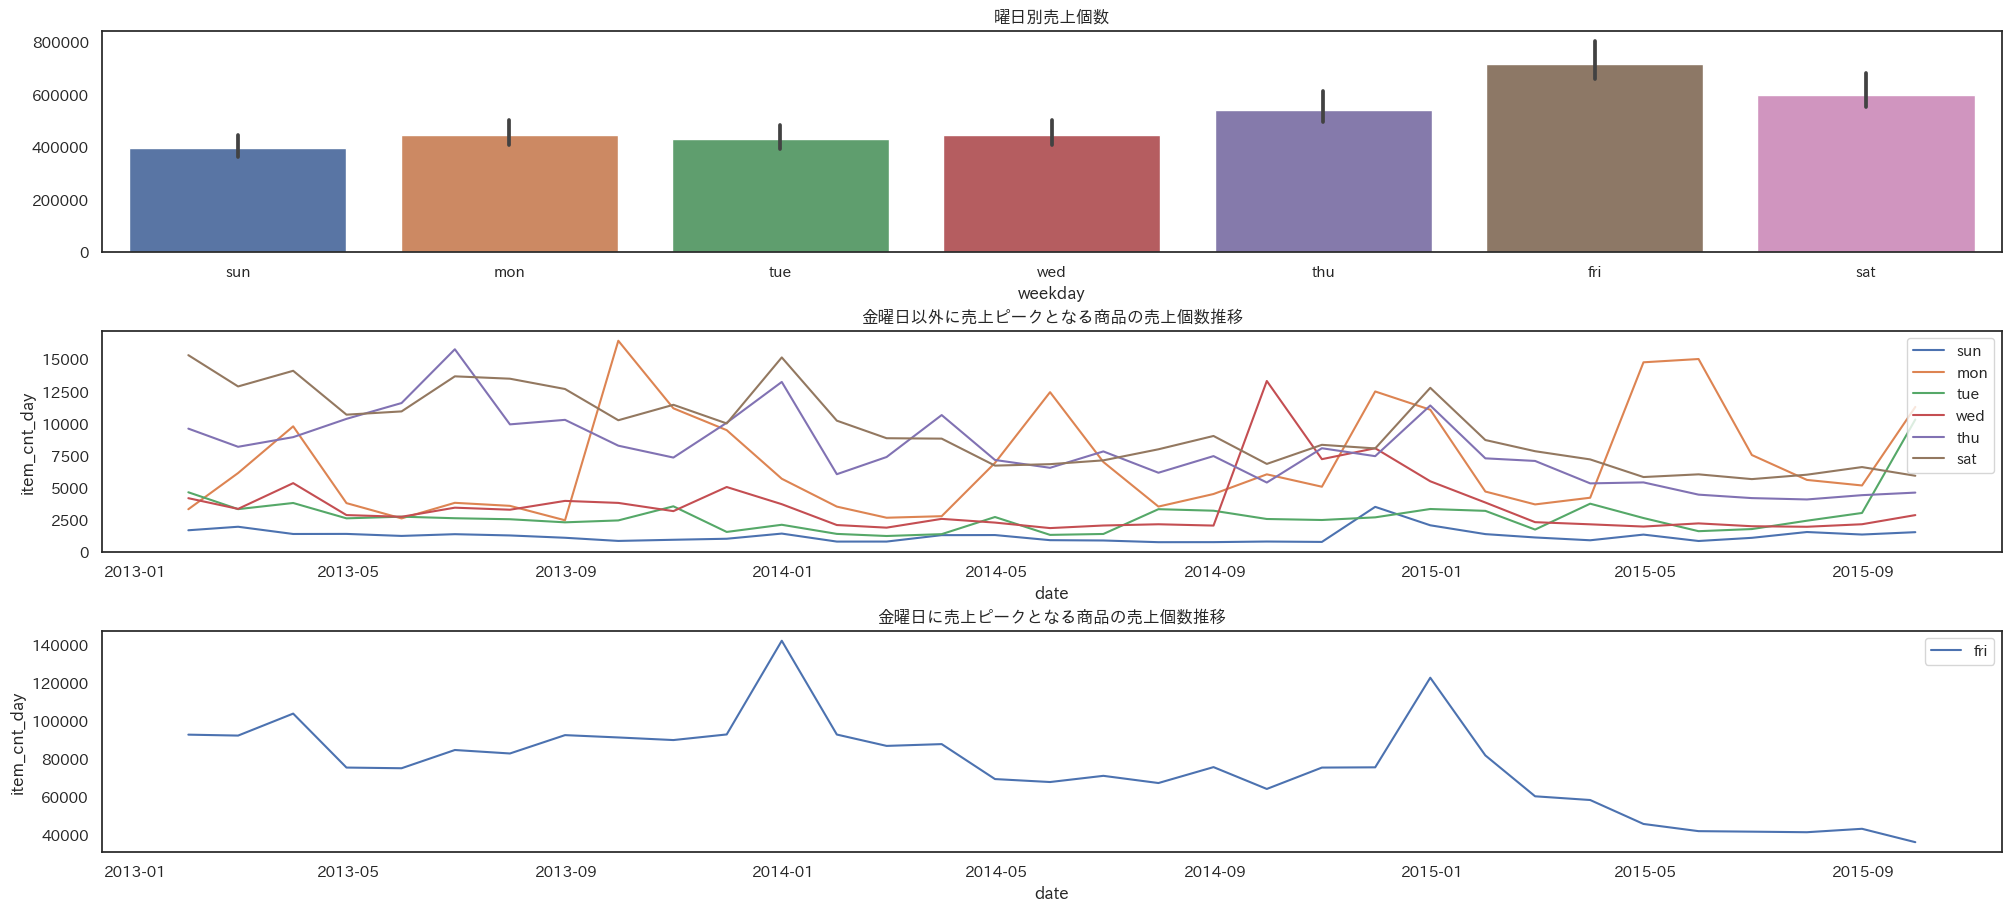

In [9]:
# weekday 分析

df['weekday'] = df['date'].dt.weekday
df_weekday = df.groupby(['item_id', 'weekday'])['item_cnt_day'].sum().unstack().fillna(0)
display(df_weekday.head())

df_sun = df_weekday[df_weekday.idxmax(axis=1) == 0]
df_mon = df_weekday[df_weekday.idxmax(axis=1) == 1]
df_tue = df_weekday[df_weekday.idxmax(axis=1) == 2]
df_wed = df_weekday[df_weekday.idxmax(axis=1) == 3]
df_thu = df_weekday[df_weekday.idxmax(axis=1) == 4]
df_fri = df_weekday[df_weekday.idxmax(axis=1) == 5]
df_sat = df_weekday[df_weekday.idxmax(axis=1) == 6]

# どの曜日に売上MAXがあるかでitem_idをキーにデータを分割
sun_data = df[df['item_id'].isin(df_sun.index)].resample('M', on='date')['item_cnt_day'].sum()
mon_data = df[df['item_id'].isin(df_mon.index)].resample('M', on='date')['item_cnt_day'].sum()
tue_data = df[df['item_id'].isin(df_tue.index)].resample('M', on='date')['item_cnt_day'].sum()
wed_data = df[df['item_id'].isin(df_wed.index)].resample('M', on='date')['item_cnt_day'].sum()
thu_data = df[df['item_id'].isin(df_thu.index)].resample('M', on='date')['item_cnt_day'].sum()
fri_data = df[df['item_id'].isin(df_fri.index)].resample('M', on='date')['item_cnt_day'].sum()
sat_data = df[df['item_id'].isin(df_sat.index)].resample('M', on='date')['item_cnt_day'].sum()

label7=['sun', 'mon', 'tue', 'wed', 'thu', 'fri', 'sat']
label6=['sun', 'mon', 'tue', 'wed', 'thu', 'sat']

df_ = [sun_data, mon_data, tue_data, wed_data, thu_data, sat_data]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,9), layout='constrained')
sns.barplot(df_weekday, estimator=np.sum, ax=ax1)
ax1.set_xticklabels(label7)
ax1.set_title('曜日別売上個数', fontsize=12)

for i, j in zip(df_, label6):
    sns.lineplot(i, label=j, legend=False, ax=ax2)
ax2.legend(loc='upper right')
ax2.set_title('金曜日以外に売上ピークとなる商品の売上個数推移', fontsize=12)

sns.lineplot(fri_data, label='fri', legend=False, ax=ax3)
ax3.legend()
ax3.set_title('金曜日に売上ピークとなる商品の売上個数推移', fontsize=12)

dic_max_weekday = {}
for id in df_weekday.index:
    dic_max_weekday[id] = df_weekday.loc[id].idxmax()

# dateの特徴量作成の観点から、item_id毎の売上個数ピークの曜日を抽出する
# 金曜日にかけて増加する傾向はあるが、中身を見ると土日に売れるものもあり、週中に売れるものもある
# 月曜日に売れる商品は年に４回ピークがある

In [10]:
# ちなみに曜日別にに売れる商品カテゴリは・・・

df_cat = df.groupby(['item_id', 'item_category_id', 'item_category_name'])[['item_cnt_day']].sum().reset_index([1,2])
for id in df_cat.index:
    df_cat.loc[id, 'weekday'] = dic_max_weekday[id]
pprint(df_cat[df_cat['weekday']==1].value_counts('item_category_name'), compact=True)

# 各曜日の売れ筋商品カテゴリを概観したところ、残念ながら一見して分かる違いはみられなかった。


item_category_name
Кино - DVD                                308
Игры PC - Цифра                           165
Кино - Blu-Ray                            130
Музыка - CD локального производства       129
Музыка - Винил                             99
Программы - Обучающие (Цифра)              72
Подарки - Фигурки                          63
Игры PC - Стандартные издания              55
Игры - XBOX 360                            52
Программы - Для дома и офиса (Цифра)       51
Игры - PS3                                 51
Программы - Для дома и офиса               48
Подарки - Атрибутика                       45
Программы - Обучающие                      42
Книги - Аудиокниги                         42
Музыка - CD фирменного производства        38
Музыка - MP3                               34
Подарки - Настольные игры                  33
Музыка - Музыкальное видео                 31
Книги - Аудиокниги (Цифра)                 31
Игры PC - Дополнительные издания           30
Подарки - Разви

* 時間もないので本件はこのくらいにするが、ChatGPTはこれらの翻訳を簡単に行ってくれる。
* 例えば以下は水曜日のリスト上位。こんな感じに訳してくれる。

```
    "Кино - DVD"：映画 - DVD（販売数：330）
    "Музыка - CD локального производства"：音楽 - ローカル製造のCD（販売数：177）
    "Кино - Blu-Ray"：映画 - Blu-Ray（販売数：127）
    "Игры PC - Цифра"：PCゲーム - デジタル（販売数：120）
    "Музыка - Винил"：音楽 - ビニール（販売数：91）
    "Игры PC - Стандартные издания"：PCゲーム - スタンダードエディション（販売数：63）
    "Подарки - Фигурки"：ギフト - フィギュア（販売数：49）
    "Книги - Аудиокниги"：書籍 - オーディオブック（販売数：48）
    "Игры - PS3"：ゲーム - PS3（販売数：47）
    "Музыка - MP3"：音楽 - MP3（販売数：45）
    "Программы - Для дома и офиса (Цифра)"：プログラム - ホーム&オフィス用（デジタル）（販売数：45）
    "Подарки - Атрибутика"：ギフト - アクセサリー（販売数：44）
    "Музыка - CD фирменного производства"：音楽 - ブランド製CD（販売数：43）
    "Подарки - Развитие"：ギフト - 開発（販売数：39）
    "Подарки - Сувениры"：ギフト - スーベニア（販売数：39）
    "Книги - Методические материалы 1С"：書籍 - 1C教育資料（販売数：36）
    "Программы - Для дома и офиса"：プログラム - ホーム&オフィス用（販売数：34）
    "Игры - XBOX 360"：ゲーム - XBOX 360（販売数：34）
    "Кино - Blu-Ray 3D"：映画 - Blu-Ray 3D（販売数：33）
    "Книги - Аудиокниги 1С"：書籍 - 1Cオーディオブック（販売数：32）
    "Музыка - Музыкальное видео"：音楽 - ミュージックビデオ（販売数：31）
    "Программы - Обучающие"：プログラム - 教育用（販売数：30）
    "Программы - Обучающие (Цифра)"：プログラム - 教育的な（デジタル）（販売数：28）
    "Кино - Коллекционное"：映画 - コレクターズアイテム（販売数：26）
```

,,item_cnt_day
shop_id,shop_name,
0,"!Якутск Орджоникидзе, 56 фран",11705.0
1,"!Якутск ТЦ ""Центральный"" фран",6311.0
2,"Адыгея ТЦ ""Мега""",29893.0
3,"Балашиха ТРК ""Октябрь-Киномир""",27742.0
4,"Волжский ТЦ ""Волга Молл""",43111.0
5,"Вологда ТРЦ ""Мармелад""",41710.0
6,"Воронеж (Плехановская, 13)",98687.0
7,"Воронеж ТРЦ ""Максимир""",65846.0
8,"Воронеж ТРЦ Сити-Парк ""Град""",3595.0


shop_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
date_block_num,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5578.0,2947.0,1146.0,767.0,2114.0,0.0,3686.0,2495.0,1463.0,0.0,935.0,0.0,842.0,1178.0,1777.0,2724.0,2978.0,0.0,2856.0,3038.0,0.0,1495.0,1924.0,1948.0,1768.0,8215.0,2331.0,5548.0,7057.0,2820.0,2978.0,10173.0,1238.0,0.0,0.0,2127.0,2399.0,1704.0,0.0,0.0,1998.0,3991.0,1759.0,1708.0,1634.0,3363.0,2115.0,0.0,0.0,3406.0,2748.0,1812.0,2055.0,9386.0,0.0,3238.0,0.0,0.0,2017.0
1,6127.0,3364.0,488.0,798.0,2025.0,877.0,4007.0,2513.0,1156.0,0.0,1026.0,0.0,1209.0,1036.0,1795.0,2746.0,2614.0,0.0,3341.0,2834.0,0.0,1854.0,2447.0,1941.0,1782.0,7934.0,2597.0,4546.0,5438.0,2834.0,2717.0,11160.0,1494.0,0.0,0.0,2205.0,2216.0,1670.0,0.0,0.0,1856.0,3965.0,2033.0,1823.0,1530.0,2660.0,1824.0,0.0,0.0,3054.0,2284.0,1737.0,1906.0,8075.0,0.0,2655.0,0.0,0.0,1897.0
2,0.0,0.0,753.0,959.0,2060.0,1355.0,4519.0,2460.0,977.0,0.0,1017.0,0.0,1419.0,1245.0,1893.0,2835.0,3088.0,0.0,3551.0,3020.0,0.0,2233.0,2588.0,2118.0,2014.0,9732.0,3036.0,5454.0,6918.0,3151.0,3026.0,12670.0,1890.0,0.0,0.0,2568.0,2629.0,2009.0,0.0,0.0,1816.0,4953.0,2504.0,2131.0,1883.0,3103.0,1977.0,0.0,0.0,3610.0,2605.0,2034.0,2365.0,9488.0,0.0,3099.0,6586.0,3773.0,2028.0
3,0.0,0.0,583.0,647.0,285.0,1008.0,3168.0,1540.0,-1.0,0.0,756.0,0.0,1364.0,1018.0,1247.0,2168.0,2118.0,0.0,2421.0,2291.0,0.0,1846.0,2297.0,1698.0,787.0,7867.0,2381.0,3946.0,4910.0,2252.0,2379.0,9621.0,1364.0,0.0,0.0,1845.0,1946.0,1375.0,0.0,0.0,1387.0,3978.0,1880.0,1628.0,1253.0,2160.0,1540.0,0.0,0.0,2740.0,1945.0,1446.0,1515.0,6726.0,0.0,2153.0,5493.0,2831.0,1388.0
4,0.0,0.0,553.0,710.0,1211.0,1110.0,3022.0,1647.0,0.0,0.0,683.0,0.0,917.0,1104.0,1489.0,1931.0,2261.0,0.0,2944.0,2089.0,0.0,1646.0,1755.0,0.0,1967.0,6860.0,2148.0,3518.0,5703.0,2345.0,2304.0,9423.0,1209.0,0.0,0.0,2048.0,2019.0,1337.0,0.0,0.0,1597.0,3594.0,1624.0,1379.0,1333.0,2522.0,1724.0,0.0,0.0,2839.0,2243.0,1482.0,1767.0,7006.0,852.0,2140.0,5233.0,2308.0,1374.0
5,0.0,0.0,832.0,784.0,1464.0,1393.0,3847.0,2085.0,0.0,0.0,764.0,0.0,1710.0,1358.0,1863.0,2419.0,3075.0,906.0,3144.0,2638.0,0.0,1912.0,2243.0,0.0,2599.0,8478.0,2661.0,275.0,7056.0,2803.0,2794.0,10072.0,1493.0,0.0,0.0,2280.0,1829.0,1539.0,0.0,0.0,2185.0,4349.0,2060.0,1666.0,1785.0,2865.0,1654.0,0.0,0.0,3761.0,2200.0,1815.0,2125.0,8101.0,728.0,3105.0,5987.0,2972.0,1707.0
6,0.0,0.0,807.0,721.0,1378.0,1265.0,3360.0,2031.0,0.0,0.0,800.0,0.0,723.0,1094.0,1709.0,2599.0,2898.0,1044.0,2676.0,2459.0,0.0,1860.0,1903.0,0.0,2377.0,7361.0,2163.0,4148.0,6739.0,2205.0,2438.0,9500.0,93.0,0.0,0.0,2041.0,1293.0,1453.0,0.0,0.0,1997.0,3801.0,1632.0,1487.0,1507.0,2966.0,1329.0,0.0,0.0,3235.0,2273.0,1616.0,1975.0,7225.0,795.0,3294.0,5827.0,3122.0,1747.0
7,0.0,0.0,875.0,890.0,1713.0,1510.0,3702.0,2397.0,0.0,0.0,755.0,0.0,1599.0,944.0,2216.0,2536.0,2457.0,1306.0,1778.0,2675.0,0.0,2061.0,2017.0,0.0,2304.0,7784.0,2452.0,4925.0,7521.0,2073.0,2799.0,9882.0,0.0,0.0,0.0,2391.0,1472.0,1895.0,0.0,0.0,2149.0,4035.0,1849.0,1610.0,1649.0,3315.0,1610.0,0.0,0.0,3718.0,2142.0,1772.0,2367.0,7792.0,719.0,3311.0,5413.0,2863.0,2048.0
8,0.0,0.0,945.0,1026.0,1536.0,1298.0,4208.0,2599.0,0.0,0.0,1027.0,0.0,2032.0,1153.0,796.0,2790.0,1924.0,1459.0,2774.0,2801.0,0.0,2486.0,2518.0,0.0,3072.0,9251.0,3206.0,4981.0,6753.0,2832.0,3023.0,11204.0,0.0,0.0,0.0,2473.0,1666.0,1666.0,0.0,0.0,2146.0,5093.0,2768.0,1849.0,1725.0,2963.0,1742.0,0.0,0.0,3655.0,1903.0,2125.0,2440.0,7827.0,812.0,2829.0,5213.0,2735.0,2008.0


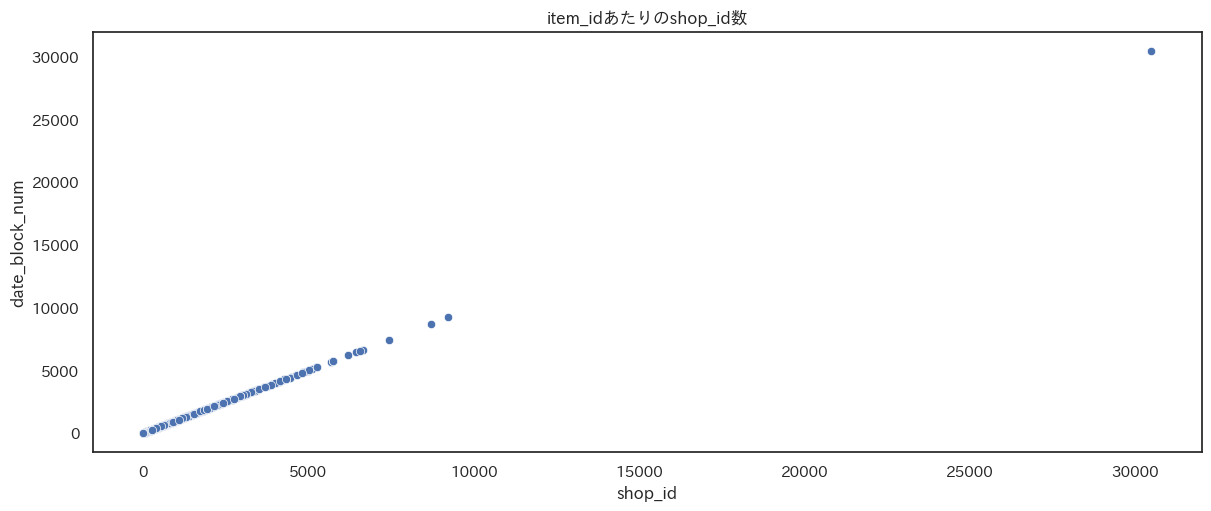

In [11]:
# shop_id, shop_name

df_sum = df.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().unstack().T
df_sum = df_sum.fillna(0)
display(df.groupby(['shop_id', 'shop_name']).sum()[['item_cnt_day']])
display(df_sum)

df_shop_num = df.groupby(['item_id'])[['shop_id', 'date_block_num']].count()
fig, ax = plt.subplots(figsize=(12,5), layout='constrained')
sns.scatterplot(data=df_shop_num, x='shop_id', y='date_block_num')
ax.set_title('item_idあたりのshop_id数', fontsize=12)

dic_shop = df[['item_id', 'shop_id']].groupby(['item_id']).sum().to_dict()


# 59店舗の動向をみるとshop_id 0,1が最初の2か月だけで57,58が3か月目からの売上計上となっている。
# shop_nameや売上水準からみて57,58は、0,1を継承しているとみて間違いなさそう。франはフランチャイズを表す。
# shop_id 10,11もほとんど同じ店舗名なので実質同じとみて良さそう。
# date_block_num 9,21にのみ売上があるshop_id 9 Выездная Торговляは「移動販売活動」
# date_block_num 21にのみ売上があるshop_id 20 Москва "Распродажа"は 「モスクワのセール」
# どちらも年に1度のイベント的な売上だとすると、次はdate_bloc_num33ということで丁度乗ってくる計算。（如何にもそれっぽい作り）
# その他、店舗に拠って売上が伸びたり減ったり入れ替わったりしているものが散見される。

# とはいえ、item_idとshop_idは多対多の関係にあるので、個別に特徴量設定するのには限界がある
# 販売チャネルの多さと販売個数には相関が想定されるのでitem_idあたりのshop_id数を特徴量にする（強い正相関が想定できる）

In [12]:
# item_category_id, item_category_name

display(df.groupby(['item_category_id', 'item_category_name']).sum()[['item_cnt_day']])

df_sum2 = df.groupby(['item_category_id', 'date_block_num'])['item_cnt_day'].sum().unstack().T
df_sum2 = df_sum2.fillna(0)
display(df_sum2)

dic_cat = df[['item_id', 'item_category_id']].groupby(['item_id']).sum().to_dict()

# item_category_id 8の売上に季節性があるが、Билеты (Цифра)は、チケット（数字）なので、これもイベント的なものだろう。
# ゲーム機やDVDなどの機器が多いので、時系列的に入れ替わりがある感じ。

# item_category_idはitem_idに対しては1対1対応なのでそのまま特徴量にできる

,,item_cnt_day
item_category_id,item_category_name,
0,PC - Гарнитуры/Наушники,3.0
1,Аксессуары - PS2,2.0
2,Аксессуары - PS3,19515.0
3,Аксессуары - PS4,28748.0
4,Аксессуары - PSP,2407.0
5,Аксессуары - PSVita,7369.0
6,Аксессуары - XBOX 360,20230.0
7,Аксессуары - XBOX ONE,5153.0
8,Билеты (Цифра),13700.0


item_category_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83
date_block_num,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,1390.0,440.0,251.0,623.0,870.0,0.0,0.0,149.0,0.0,375.0,0.0,84.0,143.0,268.0,0.0,0.0,3.0,8983.0,0.0,3492.0,1286.0,4150.0,0.0,641.0,0.0,0.0,5435.0,308.0,22216.0,0.0,0.0,291.0,0.0,422.0,0.0,6094.0,1630.0,0.0,33489.0,1789.0,0.0,1352.0,0.0,333.0,1.0,0.0,0.0,939.0,0.0,0.0,0.0,0.0,0.0,12527.0,268.0,1539.0,287.0,701.0,85.0,108.0,1724.0,1367.0,877.0,1955.0,759.0,2205.0,4.0,480.0,1465.0,149.0,802.0,677.0,0.0,2980.0,0.0,481.0,0.0,145.0,0.0,177.0,1374.0,894.0
1,1.0,1.0,1190.0,302.0,220.0,358.0,668.0,0.0,0.0,159.0,0.0,236.0,0.0,80.0,107.0,222.0,0.0,0.0,1.0,10095.0,0.0,2838.0,788.0,5275.0,0.0,475.0,0.0,0.0,6676.0,600.0,20966.0,0.0,0.0,405.0,0.0,386.0,0.0,6307.0,1375.0,0.0,31649.0,1670.0,0.0,1508.0,0.0,338.0,1.0,0.0,3.0,1097.0,0.0,0.0,0.0,0.0,0.0,11782.0,296.0,1540.0,333.0,745.0,90.0,144.0,1710.0,981.0,790.0,1935.0,680.0,2720.0,8.0,503.0,1296.0,11.0,591.0,744.0,0.0,2670.0,0.0,519.0,0.0,128.0,0.0,111.0,1192.0,574.0
2,0.0,0.0,1025.0,293.0,226.0,354.0,646.0,0.0,0.0,211.0,0.0,249.0,0.0,76.0,102.0,198.0,0.0,0.0,2.0,12327.0,0.0,2820.0,762.0,5584.0,0.0,554.0,0.0,0.0,10003.0,982.0,27045.0,0.0,0.0,343.0,0.0,592.0,0.0,6088.0,1490.0,0.0,36277.0,1667.0,0.0,1561.0,0.0,323.0,0.0,0.0,0.0,1039.0,0.0,0.0,0.0,0.0,0.0,13705.0,296.0,1564.0,377.0,850.0,67.0,111.0,1990.0,1209.0,817.0,1864.0,711.0,2199.0,21.0,694.0,1315.0,6.0,608.0,764.0,0.0,2523.0,0.0,431.0,0.0,275.0,0.0,106.0,1125.0,675.0
3,1.0,0.0,646.0,202.0,160.0,275.0,465.0,0.0,0.0,138.0,1.0,200.0,0.0,34.0,61.0,136.0,0.0,0.0,0.0,7656.0,0.0,1908.0,560.0,3581.0,0.0,538.0,0.0,0.0,5183.0,230.0,16548.0,0.0,0.0,295.0,0.0,505.0,0.0,6181.0,1612.0,0.0,27525.0,1390.0,0.0,1206.0,0.0,251.0,0.0,0.0,0.0,956.0,0.0,0.0,0.0,0.0,0.0,11739.0,334.0,1446.0,308.0,760.0,58.0,55.0,1262.0,882.0,668.0,1675.0,482.0,1615.0,8.0,545.0,1293.0,256.0,503.0,712.0,0.0,1998.0,0.0,394.0,0.0,94.0,0.0,115.0,1021.0,523.0
4,0.0,0.0,596.0,146.0,175.0,281.0,441.0,0.0,0.0,95.0,0.0,150.0,0.0,31.0,82.0,123.0,0.0,0.0,0.0,7280.0,0.0,2152.0,857.0,4005.0,0.0,627.0,0.0,0.0,3750.0,738.0,17223.0,687.0,0.0,238.0,0.0,528.0,0.0,5802.0,954.0,0.0,25470.0,1282.0,0.0,1105.0,2.0,178.0,2.0,0.0,1.0,672.0,0.0,0.0,3.0,0.0,31.0,12208.0,255.0,1393.0,345.0,622.0,63.0,46.0,1133.0,797.0,722.0,1689.0,429.0,1327.0,8.0,491.0,1164.0,3738.0,539.0,460.0,0.0,1568.0,95.0,272.0,37.0,83.0,0.0,113.0,1139.0,527.0
5,0.0,0.0,667.0,150.0,176.0,329.0,502.0,0.0,0.0,124.0,0.0,256.0,0.0,27.0,92.0,183.0,0.0,0.0,0.0,12206.0,0.0,2179.0,1147.0,4437.0,0.0,602.0,0.0,0.0,4022.0,769.0,19146.0,523.0,0.0,411.0,0.0,514.0,0.0,6763.0,1195.0,0.0,25992.0,1430.0,0.0,1192.0,4.0,199.0,0.0,0.0,0.0,687.0,0.0,0.0,0.0,0.0,21.0,13616.0,327.0,1400.0,269.0,548.0,57.0,14.0,1202.0,3236.0,739.0,1820.0,383.0,1294.0,7.0,515.0,779.0,8426.0,450.0,462.0,0.0,1442.0,98.0,256.0,82.0,64.0,0.0,75.0,1114.0,761.0
6,0.0,0.0,618.0,233.0,179.0,355.0,622.0,0.0,0.0,83.0,0.0,293.0,0.0,9.0,107.0,178.0,0.0,0.0,1.0,7497.0,0.0,1898.0,983.0,3797.0,0.0,551.0,0.0,0.0,4616.0,368.0,17285.0,602.0,0.0,337.0,0.0,458.0,0.0,8623.0,1236.0,0.0,24806.0,1045.0,0.0,1270.0,6.0,226.0,3.0,0.0,0.0,753.0,0.0,0.0,0.0,0.0,32.0,14168.0,320.0,1445.0,356.0,510.0,64.0,17.0,1091.0,1857.0,864.0,2204.0,425.0,1315.0,15.0,631.0,679.0,7269.0,468.0,506.0,0.0,1519.0,100.0,291.0,55.0,64.0,0.0,98.0,889.0,676.0
7,0.0,0.0,674.0,300.0,140.0,299.0,637.0,0.0,0.0,124.0,0.0,302.0,0.0,5.0,100.0,199.0,0.0,0.0,1.0,10488.0,0.0,1682.0,840.0,5544.0,0.0,718.0,0.0,0.0,6705.0,785.0,19340.0,544.0,85.0,334.0,0.0,556.0,0.0,8680.0,1384.0,0.0,24130.0,1169.0,0.0,1116.0,4.0,208.0,0.0,0.0,0.0,685.0,0.0,0.0,0.0,0.0,30.0,14131.0,260.0,1316.0,284.0,399.0,46.0,19.0,1145.0,1688.0,942.0,2446.0,369.0,1248.0,9.0,665.0,786.0,7296.0,717.0,488.0,0.0,163

(-1000.000, 50000.000)

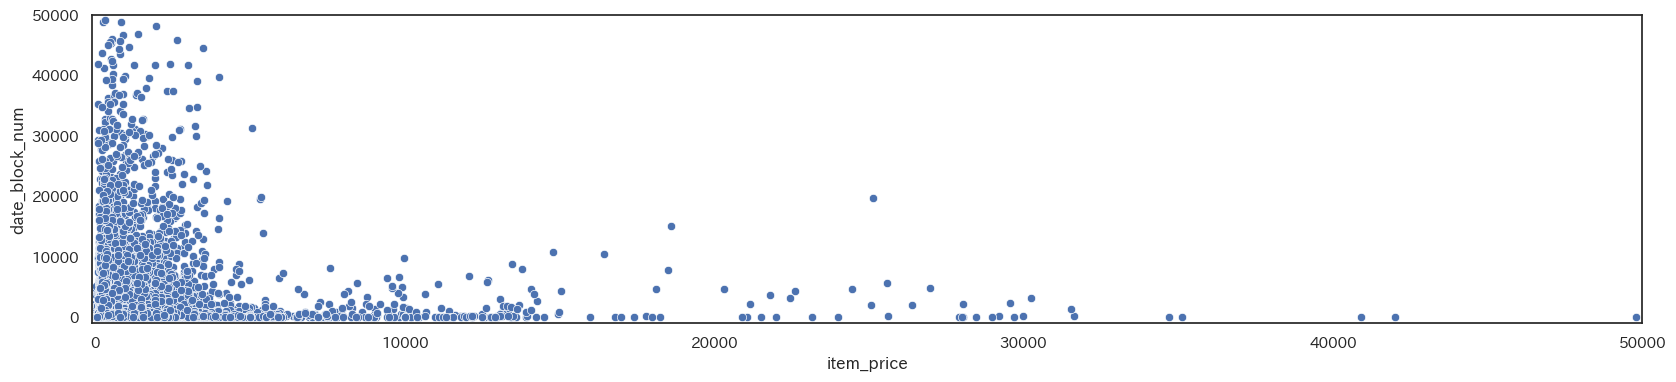

In [13]:
# item_id, item_name, item_price

df_num_price = df[['item_id', 'date_block_num', 'item_price']] \
    .groupby(['item_id'])[['date_block_num', 'item_price']].agg({'date_block_num': 'sum', 'item_price':'mean'})
dic_price = df[['item_id', 'item_price']].groupby(['item_id']).mean().to_dict()

fig, ax = plt.subplots(figsize=(20, 4))
sns.scatterplot(data=df_num_price, x='item_price', y='date_block_num', ax=ax)
ax.set_xlim(-100, 50000)
ax.set_ylim(-1000, 50000)

# 同じ商品でも価格はいろいろ（何倍も違うケースも）
# そもそもitem_idが20000種類以上あるから、これはちょっとキリがない感じ。
# 月別の個数予測だから、取り敢えずpriceは情報として勘案しなくても良いが、販売個数と平均単価の関係くらいは見ておく。

# 販売個数と単価mean_priceは逆相関っぽいので、そういう特徴量になる


In [14]:
# df_testとdfのitem_idの要素の数が一致しない問題

print(len(set(df_test['item_id']) - set(df['item_id'])))
print(set(df_test['item_id']) - set(df['item_id']))

# submittして気づいたが、df_testには22170個のitem_idがあるのに対しdf_trainには21332個しかないことが判明。
# 差が838個ある。テストデータが訓練データと切り分けられているのはテーブルデータでは普通。
# でも、時系列回帰問題の目的変数は時点だから、全てのitem_idが揃っていなくてはそもそも予想できない。

838
{20486, 6152, 6153, 2066, 6169, 12332, 14383, 18483, 20535, 4156, 10310, 20560, 20561, 18514, 83, 2131, 20564, 12382, 20577, 16498, 6259, 20594, 20599, 12408, 12409, 20600, 18560, 10372, 8327, 138, 139, 140, 20618, 20619, 20621, 8337, 146, 147, 12441, 20637, 159, 8354, 8355, 168, 12460, 173, 174, 12468, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 6335, 192, 193, 194, 12474, 14525, 18627, 20677, 20680, 201, 204, 8397, 8398, 10447, 208, 10448, 10449, 6356, 4310, 16601, 4318, 229, 8428, 237, 238, 10483, 245, 249, 254, 8453, 8454, 12671, 8456, 10507, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 12568, 20760, 12574, 16675, 18723, 6439, 302, 12591, 14647, 14648, 18743, 315, 4412, 20796, 20801, 12612, 14662, 2390, 8545, 8546, 20836, 8549, 12646, 8551, 20837, 6505, 20843, 364, 20845, 2420, 14709, 6519, 6520, 2425, 2426, 2427, 2428, 6521, 6522, 6523, 6524, 6525, 2434, 6526, 6527, 6528, 6529, 6530, 6531, 6532, 6533, 20878, 20879, 12688, 14736, 402, 14739, 20880, 409, 16797, 12706, 14760, 

## 特徴量エンジニアリング

In [15]:
# 訓練用データ
df = pd.read_csv('C:\\Users\\yuich\\KC_data\\sales\\train.csv')[['date_block_num', 'item_id', 'item_category_id', 'item_cnt_day']]
# 提出用データ
df_test = pd.read_csv('C:\\Users\\yuich\\KC_data\\sales\\test.csv')

# モデルに適用するテーブルデータを作成するにあたり、必要なデータに絞って再読み込みする

In [16]:
df.head()

,date_block_num,item_id,item_category_id,item_cnt_day
0,0,22154,37,1.0
536424,0,4907,23,1.0
536423,0,4907,23,1.0
246988,0,2258,28,1.0
246989,0,2258,28,1.0


In [17]:
# df_base（機械学習モデルに特徴量と目的変数を設定するベースの形式）

# まずは、item_idとdate_block_numでgroupbyしてベースの表の形を作る
df_base = df[['item_id', 'date_block_num','item_cnt_day']].groupby(['item_id', 'date_block_num']).sum().unstack().fillna(0)
display(df_base.head())

# そのままだとMultiIndexになっていて扱いづらいので、valuesだけ抜き取って別途indexとcolumnsを振り直してベースの表を完成させる
# 正解動画ではpivot_tableを使って変換していたが、ここではvaluesを分離して任意のindex, columnsをコンストラクタを用いて外付けするというより明確な方法を採用している
df_base = pd.DataFrame(np.array(df_base.values),
                       index=df_base.index,
                       columns=[str(i) for i in range(33)])
display(df_base.head())
display(df_base.info())

# 加工用にname類のないデータで改めて訓練データを読み込みベースのデータフレームの形式を整える

item_cnt_day                                                    \
date_block_num           0    1    2    3    4    5    6    7    8    9    10   
item_id                                                                         
0                       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1                       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2                       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3                       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4                       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                                                                            \
date_block_num   11   12   13   14   15   16   17   18   19   20   21   22   
item_id                                                                      
0               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
1               0.0  0.0  0.0  0.0  2.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
2               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
3               0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0   
4               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   

                                                                  
date_block_num   23   24   25   26   27   28   29   30   31   32  
item_id                                                           
0               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
item_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 21332 entries, 0 to 22169
Data columns (total 33 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       21332 non-null  float64
 1   1       21332 non-null  float64
 2   2       21332 non-null  float64
 3   3       21332 non-null  float64
 4   4       21332 non-null  float64
 5   5       21332 non-null  float64
 6   6       21332 non-null  float64
 7   7       21332 non-null  float64
 8   8       21332 non-null  float64
 9   9       21332 non-null  float64
 10  10      21332 non-null  float64
 11  11      21332 non-null  float64
 12  12      21332 non-null  float64
 13  13      21332 non-null  float64
 14  14      21332 non-null  float64
 15  15      21332 non-null  float64
 16  16      21332 non-null  float64
 17  17      21332 non-null  float64
 18  18      21332 non-null  float64
 19  19      21332 non-null  float64
 20  20      21332 non-null  float64
 21  21      21332 non-null  float64
 22

None

In [18]:
# 特徴量 item_category_id

for id in df_base.index:
    df_base.at[id, 'item_category'] = dic_cat['item_category_id'][id]

# 以下、時系列データ以外の特徴量を追加する。まずは1隊1対応しているitem_categoryを加える

In [19]:
# 特徴量　mean_price

for id in df_base.index:
    df_base.at[id, 'mean_price'] = dic_price['item_price'][id]

# item_priceから平均単価を加える

In [20]:
# 特徴量 shop_num

for id in df_base.index:
    df_base.at[id, 'shop_num'] = dic_shop['shop_id'][id]

# shop_idからitem_idあたりのショップ数を加える

In [21]:
# 特徴量 max_weekday

for id in df_base.index:
    df_base.at[id, 'max_weekday'] = dic_max_weekday[id]

df_base.head()

# dateから売上個数が最大の曜日を特徴量に加える

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,item_category,mean_price,shop_num,max_weekday
item_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,58.0,54.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,456.0,4490.0,330.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,58.0,108.0,2.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,79.0,108.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,58.0,54.0,4.0


* df_baseは未だ最終形ではないので、ここから必要な特徴量を選択および作成してモデルに適用するテーブルデータ（X_train, X_test）にする
* 通常の機械学習問題だと、X_train, X_testは目的変数を切り出すだけ、あるいは不要な特徴量を削除するだけだが時系列の場合はここからの作業がある


## 機械学習モデルの適用

(-0.500, 32.500)

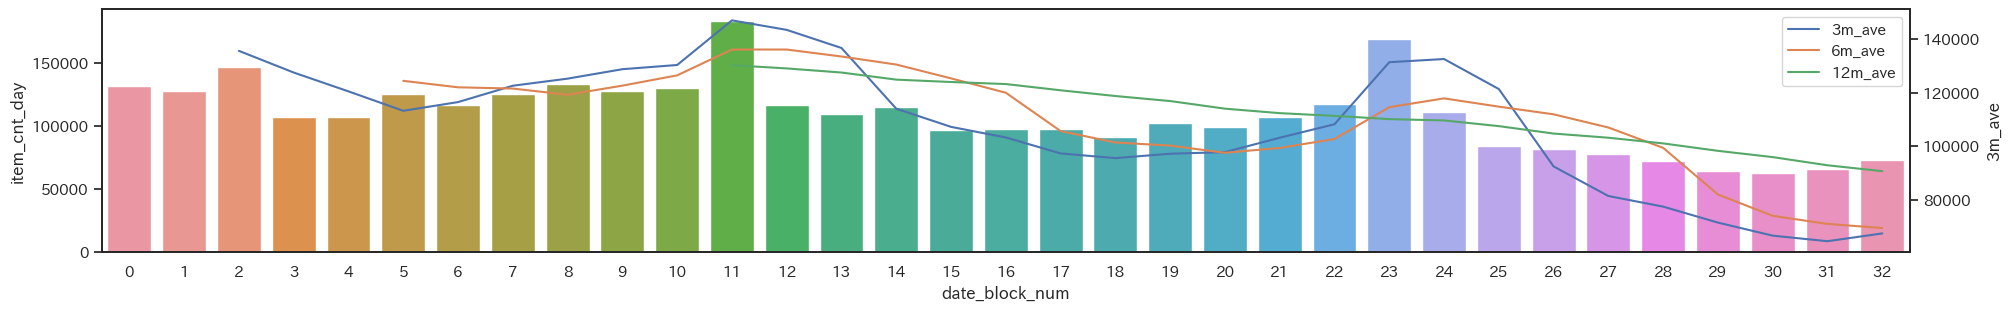

In [22]:
# 時系列グラフの再掲

df_sum = df.groupby('date_block_num')['item_cnt_day'].sum().reset_index()
df_sum['3m_ave'] = df_sum['item_cnt_day'].rolling(window=3).mean()
df_sum['6m_ave'] = df_sum['item_cnt_day'].rolling(window=6).mean()
df_sum['12m_ave'] = df_sum['item_cnt_day'].rolling(window=12).mean()


fig, ax = plt.subplots(figsize=(20,3), layout='constrained')
sns.barplot(data=df_sum, x='date_block_num', y='item_cnt_day', ax=ax)
axt = ax.twinx()
sns.lineplot(data=df_sum, x='date_block_num', y='3m_ave', label='3m_ave', ax=axt)
sns.lineplot(data=df_sum, x='date_block_num', y='6m_ave', label='6m_ave', ax=axt)
sns.lineplot(data=df_sum, x='date_block_num', y='12m_ave', label='12m_ave', ax=axt)
axt.legend()
ax.set_xlim(-0.5, 32.5)

### モデルシミュレーション

In [23]:
# ⇒ 機械学習のAPIにデータ形式を合わせる（df_baseから改めてX_trainやX_testを作成する）
#    上で作成した時系列以外の特徴量と代表的な時系列特徴量を設定
# ⇒ 指定の複数のtest_colでバリデーションを実施
#    正解動画では前年同月を教師とする1パターンだけ示されていたが、
#    時系列にはいろいろな組み合わせがあるのでシミュレートすることが必要と思う。

test_col = [i for i in df_base.columns[21:33]]                                 # 前年同月から前月までの12カ月でシミュレートする
RMSE = defaultdict(int)
r2 = defaultdict(int)
counter = 0

for y in test_col:
    n = list(df_base.columns).index(y)
    X_train = pd.DataFrame()
    X_train = df_base[['item_category']]                                        # item_category(from item_category_id)
    X_train['mean_price'] = df_base['mean_price']                               # mean_price(from item_price)
    X_train['shop_num'] = df_base['shop_num']                                   # shop_num(from shop_id)
    X_train['max_weekday'] = df_base['max_weekday']                             # max_weekday(from date)
    X_train['1m'] = df_base[str(n-2)]                                           # y_trainの前月
    X_train['3m_mean'] = df_base.loc[:, str(n-4): str(n-1)].sum(axis=1) / 3     # y_trainの前月までの3か月平均
    X_train['6m_mean'] = df_base.loc[:, str(n-7): str(n-1)].sum(axis=1) / 6     # y_trainの前月までの6か月平均
    X_train['12m'] = df_base[str(n-13)]                                         # y_trainの1年前
    X_train['12m_mean'] = df_base.loc[:, str(n-13): str(n-1)].sum(axis=1) / 12  # y_trainの前月までの1年平均
    y_train = df_base[str(n-1)]                                                 # y_test の1か月前

    X_test = pd.DataFrame()
    X_test = df_base[['item_category']]
    X_test['mean_price'] = df_base['mean_price']
    X_test['shop_num'] = df_base['shop_num']
    X_test['max_weekday'] = df_base['max_weekday']
    X_test['1m'] = df_base[str(n-1)]
    X_test['3m_mean'] = df_base.loc[:, str(n-3): str(n)].sum(axis=1) / 3
    X_test['6m_mean'] = df_base.loc[:, str(n-6): str(n)].sum(axis=1) / 6
    X_test['12m'] = df_base[str(n-12)]
    X_test['12m_mean'] = df_base.loc[:, str(n-12): str(n)].sum(axis=1) / 12
    y_test = df_base[y]

# 以下、重回帰と決定木で予測を行い、RMSEとr2決定係数を算定

    LR_model = LR()
    tree_model = tree.DecisionTreeRegressor()

    for model in [LR_model, tree_model]:
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        print(f'目的変数: {y} model: {model} \
              {"     " if model== LR_model else ""} \
              RMSE: {np.sqrt(mean_squared_error(pred, y_test)).round(3)} \
              決定係数: {r2_score(y_test, pred).round(3)}')
        if model==LR_model:
            RMSE['LR_model'] += np.sqrt(mean_squared_error(pred, y_test))
            r2['LR_model'] += r2_score(y_test, pred)
        else:
            RMSE['tree_model'] += np.sqrt(mean_squared_error(pred, y_test))
            r2['tree_model'] += r2_score(y_test, pred)
    counter += 1

print(f'\nRMSE ave    : {(RMSE["LR_model"] / counter).round(3)} model: LR_model \
      {(RMSE["tree_model"] / counter).round(3)} model: tree_model \
      \n決定係数 ave : {(r2["LR_model"] / counter).round(3)} model: LR_model \
      {(r2["tree_model"] / counter).round(3)} model: tree_model')


# 予測の性能は目的変数をどの月にするかで大きく変わる
# それは、循環する季節性やトレンドが認められても不確定要素があり、その発現自体が不確定だから
# つまり、全てがベースラインモデルとも言え、特定の目的変数に最適化したモデルはその目的変数に対する過学習でしかない
# 目的変数の時系列データ以外のテーブルデータの特徴量は、本来の意味はあるのだろうけど時系列に対してはなかなか厳しい感じ

# 目的変数を21（前年同月）から32（前月）まで変化させた時の平均スコアでモデルの性能を評価
# 結論的にはLR_modelの3m_meanだけで予測した結果がベストだが、それが普遍的に当て嵌まると考えるのはおそらく間違い


目的変数: 21 model: LinearRegression()                                   RMSE: 30.924               決定係数: 0.677
目的変数: 21 model: DecisionTreeRegressor()                              RMSE: 30.956               決定係数: 0.676
目的変数: 22 model: LinearRegression()                                   RMSE: 32.393               決定係数: 0.786
目的変数: 22 model: DecisionTreeRegressor()                              RMSE: 36.925               決定係数: 0.723
目的変数: 23 model: LinearRegression()                                   RMSE: 38.016               決定係数: 0.833
目的変数: 23 model: DecisionTreeRegressor()                              RMSE: 46.67               決定係数: 0.749
目的変数: 24 model: LinearRegression()                                   RMSE: 37.249               決定係数: 0.614
目的変数: 24 model: DecisionTreeRegressor()                              RMSE: 39.277               決定係数: 0.571
目的変数: 25 model: LinearRegression()                                   RMSE: 28.256               決定係数: 0.069
目的変数: 25 model: DecisionTreeR

### 前月基準でRFGモデルも加えて再計算

In [24]:
# 重回帰

LR_model = LR()
LR_model.fit(X_train, y_train)
LR_pred = LR_model.predict(X_test)

# RMSE
# 決定係数R2

print(np.sqrt(mean_squared_error(LR_pred, y_test)))
print(r2_score(y_test, LR_pred))


25.352798933229394
0.5550187689490711


In [25]:
# 決定木

tree_model = tree.DecisionTreeRegressor()
tree_model.fit(X_train, y_train)
tree_pred = tree_model.predict(X_test)

# RMSE

print(np.sqrt(mean_squared_error(tree_pred, y_test)))
print(r2_score(y_test, tree_pred))

# 3m_meanだけのシミュレーションでは当て嵌まりの悪い決定木だが、いろいろ組み合わせるとスコアアップしたりする


23.689072074661027
0.6115045225591842


In [26]:
# RFG

RFG_model = RFG()
RFG_model.fit(X_train, y_train)
RFG_pred = RFG_model.predict(X_test)

# RMSE

print(np.sqrt(mean_squared_error(RFG_pred, y_test)))
print(r2_score(y_test, RFG_pred))


23.796583483389064
0.6079701944940994


In [27]:
# モデルの係数表示（Linear_model）

pd.DataFrame({'LR_coefficient':LR_model.coef_}, index=X_train.columns, )

,LR_coefficient
item_category,6.641e-05
mean_price,1.052e-06
shop_num,-5.891e-05
max_weekday,4.648e-02
1m,3.471e-01
3m_mean,2.066e-01
6m_mean,3.751e-02
12m,6.281e-03
12m_mean,1.813e-01


Text(0.5, 1.0, 'RFG_model')

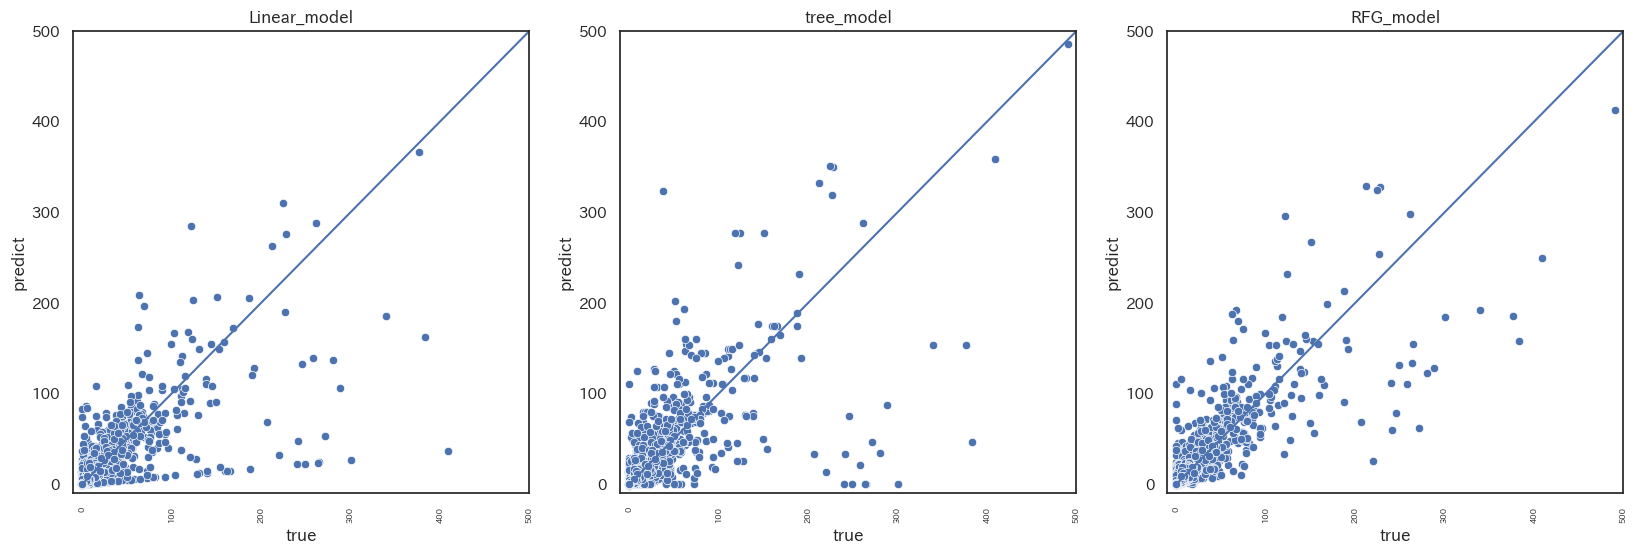

In [28]:
# 予測と正解の分布の可視化

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
sns.scatterplot(x=y_test, y=LR_pred, ax=ax1)
sns.lineplot(x=y_test, y=y_test, ax=ax1)
ax1.set_xlabel('true')
ax1.set_ylabel('predict')
ax1.set_xlim(-10, 500)
ax1.set_ylim(-10, 500)
ax1.tick_params(axis='x', rotation=90, labelsize=6)
ax1.set_title('Linear_model')

sns.scatterplot(x=y_test, y=tree_pred, ax=ax2)
sns.lineplot(x=y_test, y=y_test, ax=ax2)
ax2.set_xlabel('true')
ax2.set_ylabel('predict')
ax2.set_xlim(-10, 500)
ax2.set_ylim(-10, 500)
ax2.tick_params(axis='x', rotation=90, labelsize=6)
ax2.set_title('tree_model')

sns.scatterplot(x=y_test, y=RFG_pred, ax=ax3)
sns.lineplot(x=y_test, y=y_test, ax=ax3)
ax3.set_xlabel('true')
ax3.set_ylabel('predict')
ax3.set_xlim(-10, 500)
ax3.set_ylim(-10, 500)
ax3.tick_params(axis='x', rotation=90, labelsize=6)
ax3.set_title('RFG_model')


Text(0.5, 1.0, 'tree_pred')

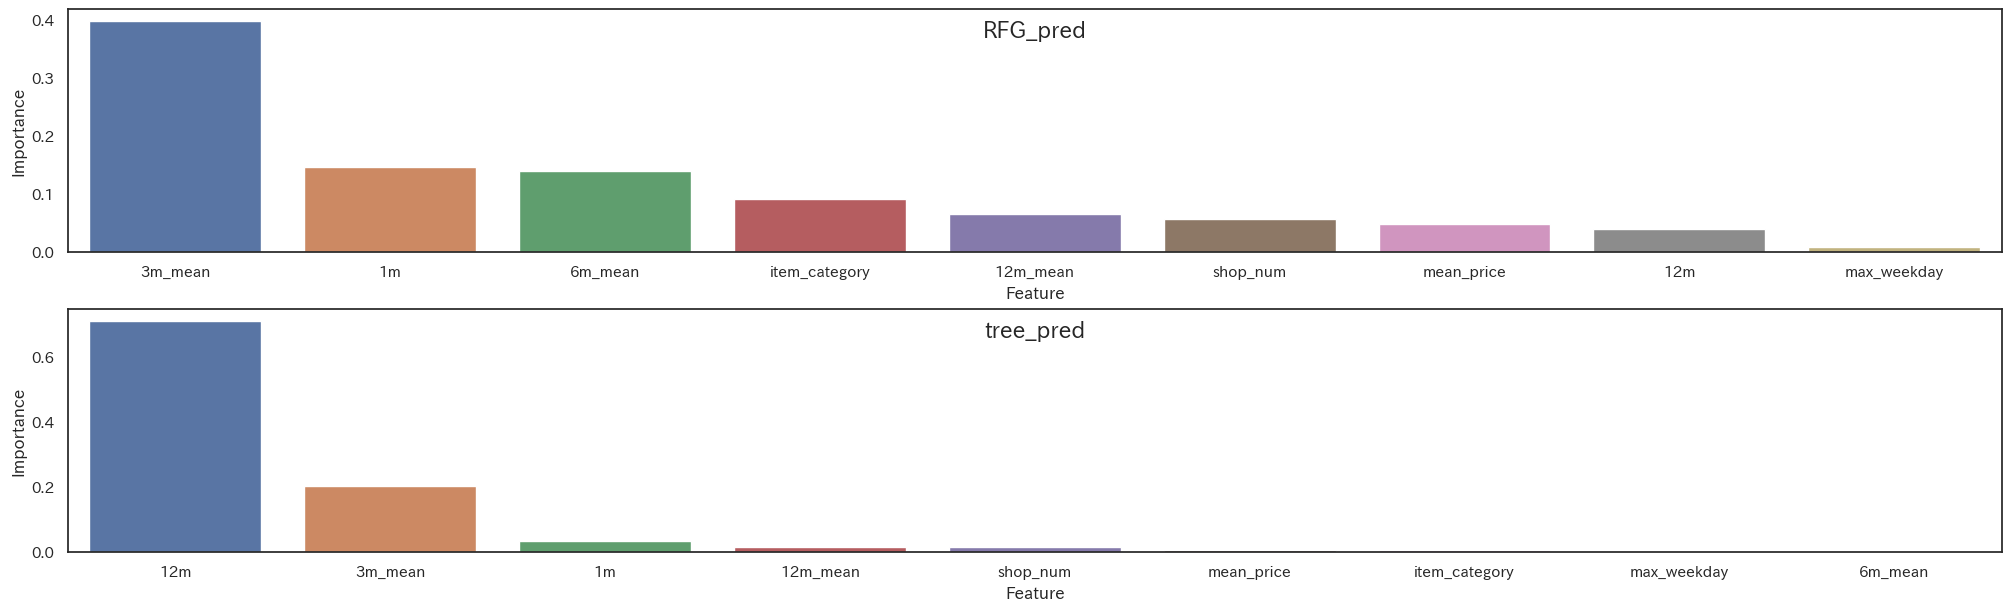

In [29]:
# 特徴量の重要度の可視化(RFG)

importance_RFG = RFG_model.feature_importances_
importance_df_RFG = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance_RFG})
importance_df_RFG = importance_df_RFG.sort_values('Importance', ascending=False)

importance_tree = tree_model.feature_importances_
importance_df_tree = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance_tree})
importance_df_tree = importance_df_tree.sort_values('Importance', ascending=False)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6), layout='constrained')
sns.barplot(data=importance_df_RFG, x='Feature', y='Importance', ax=ax1)
sns.barplot(data=importance_df_tree, x='Feature', y='Importance', ax=ax2)
ax1.set_title('RFG_pred', pad=-20, fontsize=16)
ax2.set_title('tree_pred', pad=-20, fontsize=16)


In [30]:
# Light gbm

params = {"objective": "regression","metrics": "rmse"}
trains = lgb.Dataset(X_train, y_train)
valids = lgb.Dataset(X_test, y_test)
lgb_model = lgb.train(params, trains, valid_sets=valids,
                      num_boost_round=2000, early_stopping_rounds=100)

lgb_pred = lgb_model.predict(X_test)

print(np.sqrt(mean_squared_error(lgb_pred, y_test)))

lgb_pred = lgb_pred.round(0)
print(np.sqrt(mean_squared_error(lgb_pred, y_test)))

# 一応、Light gbmもやっておくが、結果はそれほどでもない

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1781
[LightGBM] [Info] Number of data points in the train set: 21332, number of used features: 9
[LightGBM] [Info] Start training from score 3.097647
[1]	valid_0's rmse: 36.8719
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 35.8903
[3]	valid_0's rmse: 35.0228
[4]	valid_0's rmse: 34.312
[5]	valid_0's rmse: 33.6801
[6]	valid_0's rmse: 33.1687
[7]	valid_0's rmse: 32.9346
[8]	valid_0's rmse: 32.682
[9]	valid_0's rmse: 32.4471
[10]	valid_0's rmse: 32.2173
[11]	valid_0's rmse: 32.0734
[12]	valid_0's rmse: 31.8927
[13]	valid_0's rmse: 31.6915
[14]	valid_0's rmse: 31.5893
[15]	valid_0's rmse: 31.3948
[16]	valid_0's rmse: 31.3297
[17]	valid_0's rmse: 31.1577
[18]	valid_0's rmse: 31.0618
[19]	valid_0's rmse